In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
mnist = pickle.Unpickler(open('mnist.pkl', 'rb'), encoding = 'latin1').load()

(train, validation, test) = mnist
(train_images, train_labels) = train
(validation_images, validation_labels) = validation
(test_images, test_labels) = test

image_size = 28
features_size = 784
classes_count = 10

print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

(50000, 784)
(10000, 784)
(10000, 784)


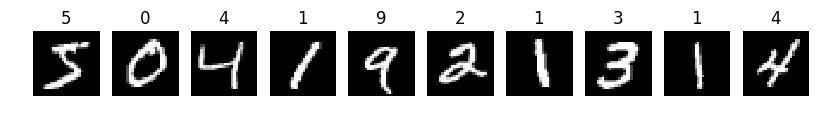

In [3]:
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(str(train_labels[i]))
    plt.imshow(train_images[i].reshape((image_size, image_size)))
    plt.axis('off')

epoch 0: accuracy = 0.135000, validation_accuracy = 0.109000, loss = 2.302573
epoch 200: accuracy = 0.320000, validation_accuracy = 0.278000, loss = 1.714857
epoch 400: accuracy = 0.735000, validation_accuracy = 0.691800, loss = 0.752104
epoch 600: accuracy = 0.905000, validation_accuracy = 0.924300, loss = 0.347102
epoch 800: accuracy = 0.945000, validation_accuracy = 0.940000, loss = 0.182452
epoch 1000: accuracy = 0.950000, validation_accuracy = 0.951800, loss = 0.179264
epoch 1200: accuracy = 0.965000, validation_accuracy = 0.955000, loss = 0.129769
epoch 1400: accuracy = 0.975000, validation_accuracy = 0.960700, loss = 0.111252
epoch 1600: accuracy = 0.950000, validation_accuracy = 0.962700, loss = 0.202167
epoch 1800: accuracy = 0.975000, validation_accuracy = 0.964900, loss = 0.098820
epoch 2000: accuracy = 0.975000, validation_accuracy = 0.968000, loss = 0.074013
epoch 2200: accuracy = 0.960000, validation_accuracy = 0.968600, loss = 0.126626
epoch 2400: accuracy = 0.980000, va

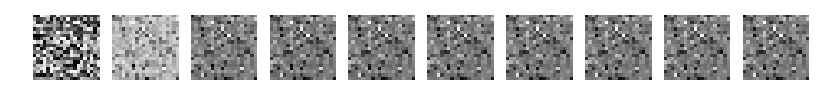

In [4]:
hidden_neurons = 400
minibatch_size = 200
regularization_factor = 1e-6
learning_rate = 0.5
learning_rate_decay = 0.999

# 2 relu layers, 1 output softmax layer
# it's actually stemmed 4 layers network hence strange names of variables

W2 = np.random.uniform(high = 1.0 / features_size, size = (features_size, hidden_neurons))
b2 = np.zeros(shape = (hidden_neurons,))
W3 = np.random.uniform(high = 1.0 / hidden_neurons, size = (hidden_neurons, hidden_neurons))
b3 = np.zeros(shape = (hidden_neurons,))
W4 = np.random.uniform(high = 1.0 / hidden_neurons, size = (hidden_neurons, classes_count))
b4 = np.zeros(shape = (classes_count,))

learning_history = []

for epoch in range(5000):
    choice = np.random.choice(train_images.shape[0], minibatch_size)
    X = train_images[choice]
    y = train_labels[choice]
    
    # forward pass
    H1 = X
    H2 = np.maximum(np.dot(H1, W2) + b2, 0)
    H3 = np.maximum(np.dot(H2, W3) + b3, 0)
    H4 = np.dot(H3, W4) + b4

    scores = H4 - np.max(H4, axis = 1, keepdims = True)
    probs = np.exp(scores)
    probs /= np.sum(probs, axis = 1, keepdims = True)
    labels = np.argmax(probs, axis = 1)

    accuracy = np.mean(labels == y)    

    loss = np.sum(-np.log(probs[range(minibatch_size), y])) / minibatch_size
    loss += 0.5 * regularization_factor * (np.sum(W2 * W2) + np.sum(b2 * b2))
    loss += 0.5 * regularization_factor * (np.sum(W3 * W3) + np.sum(b3 * b3))
    loss += 0.5 * regularization_factor * (np.sum(W4 * W4) + np.sum(b4 * b4))
    
    if epoch % 200 == 0:
        H1v = validation_images
        H2v = np.maximum(np.dot(H1v, W2) + b2, 0)
        H3v = np.maximum(np.dot(H2v, W3) + b3, 0)
        H4v = np.dot(H3v, W4) + b4
        validation_pred = np.argmax(H4v, axis = 1)
        validation_accuracy = np.mean(validation_labels == validation_pred)
        learning_history.append((accuracy, validation_accuracy, loss))

        print('epoch %d: accuracy = %f, validation_accuracy = %f, loss = %f' % (epoch, accuracy, validation_accuracy, loss))
        
    if epoch % 500 == 0:
        plt.subplot(1, 10, epoch / 500 + 1)
        #plt.imshow(W2[:, 100].reshape(image_size, image_size))
        plt.imshow(W3[:, 100].reshape(20, 20))
        plt.axis('off')

    # backprop
    # layer 4
    dL_dH4 = np.array(probs)
    dL_dH4[range(minibatch_size), y] -= 1
    dL_dH4 /= minibatch_size

    dH4_dW4 = np.array(H3)

    dL_dW4 = np.dot(dH4_dW4.T, dL_dH4)
    dL_dW4 += regularization_factor * W4
    dL_db4 = np.sum(dL_dH4, axis = 0)
    dL_db4 += regularization_factor * b4
    
    # layer 3
    dH3_dW3 = np.array(H2)
    dH3_db3 = np.ones(shape = H2.shape[0])  
    
    dH4_dH3 = np.array(W4)
    
    dL_dH3 = np.dot(dL_dH4, dH4_dH3.T)
    dL_dH3[H3 <= 0] = 0
    
    dL_dW3 = np.dot(dH3_dW3.T, dL_dH3)
    dL_dW3 += regularization_factor * W3
    dL_db3 = np.dot(dH3_db3.T, dL_dH3)
    dL_db3 += regularization_factor * b3

    # layer 2
    dH2_dW2 = np.array(H1)
    dH2_db2 = np.ones(shape = H1.shape[0])  
    
    dH3_dH2 = np.array(W3)
    
    dL_dH2 = np.dot(dL_dH3, dH3_dH2.T)
    dL_dH2[H2 <= 0] = 0
    
    dL_dW2 = np.dot(dH2_dW2.T, dL_dH2)
    dL_dW2 += regularization_factor * W2
    dL_db2 = np.dot(dH2_db2.T, dL_dH2)
    dL_db2 += regularization_factor * b2

    # sgd step
    W4 += - learning_rate * dL_dW4
    b4 += - learning_rate * dL_db4
    W3 += - learning_rate * dL_dW3
    b3 += - learning_rate * dL_db3
    W2 += - learning_rate * dL_dW2
    b2 += - learning_rate * dL_db2
    
    learning_rate *= learning_rate_decay


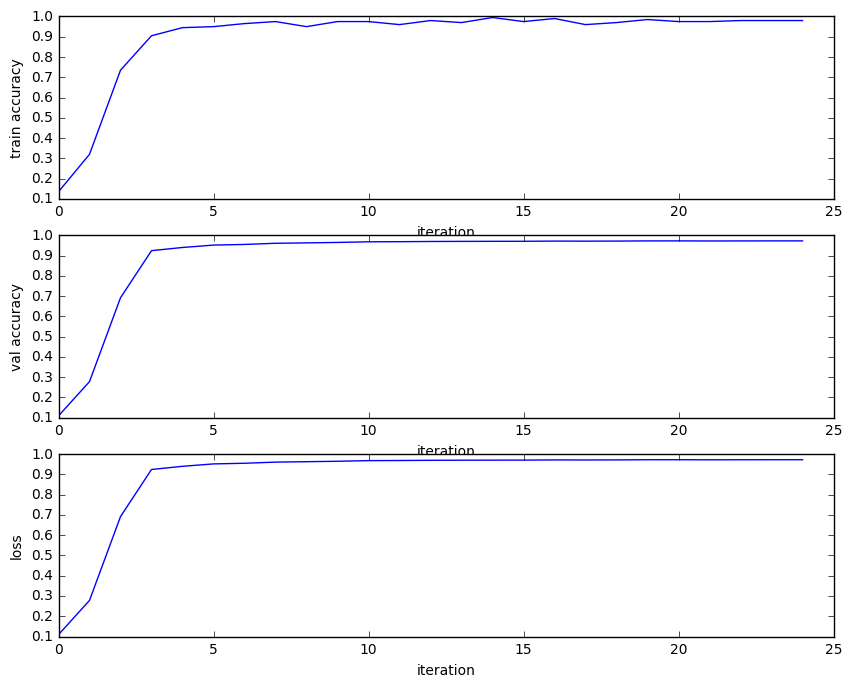

In [5]:
plt.subplot(3, 1, 1)
plt.plot([x[0] for x in learning_history])
plt.xlabel('iteration')
plt.ylabel('train accuracy')

plt.subplot(3, 1, 2)
plt.plot([x[1] for x in learning_history])
plt.xlabel('iteration')
plt.ylabel('val accuracy')

plt.subplot(3, 1, 3)
plt.plot([x[1] for x in learning_history])
plt.xlabel('iteration')
plt.ylabel('loss')

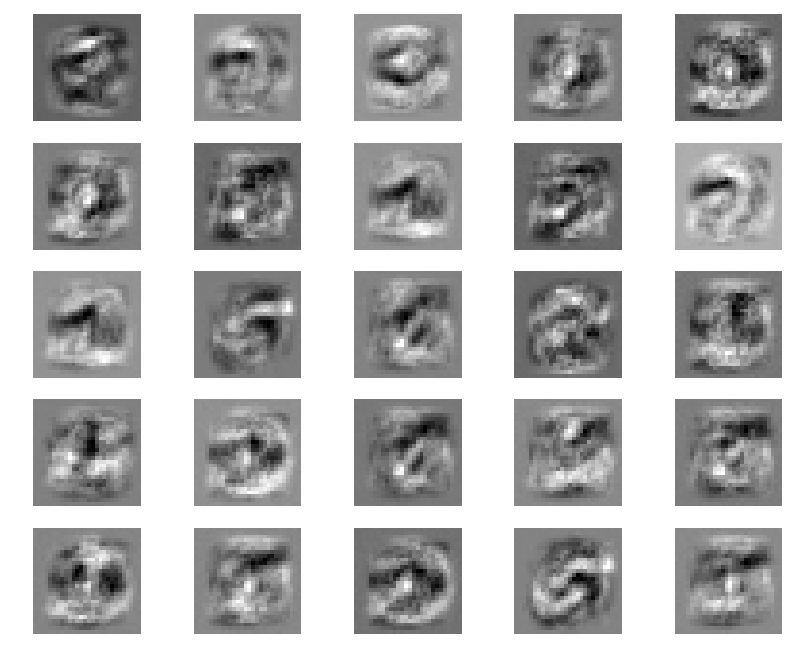

In [6]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(W2[:, i * 10].reshape(image_size, image_size))
    plt.axis('off')

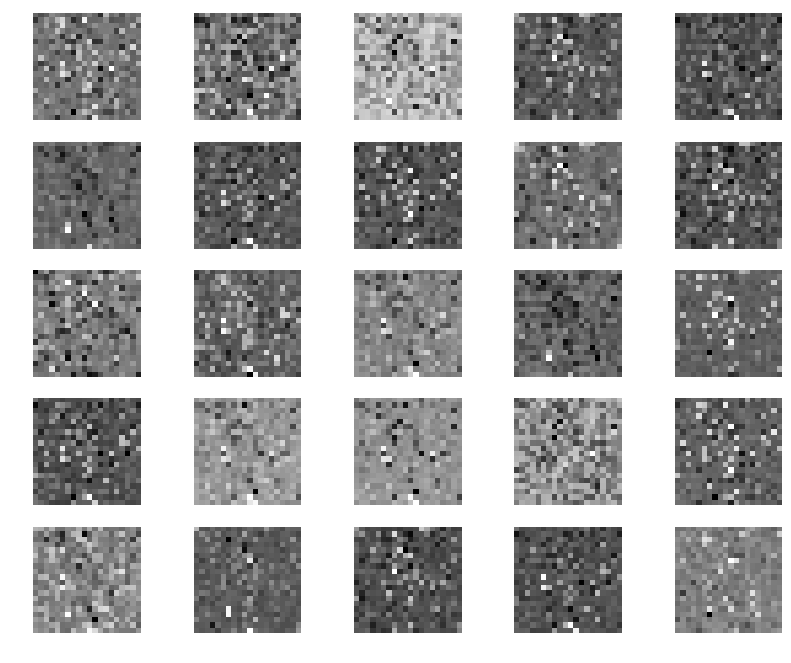

In [7]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(W3[:, i * 10].reshape(20, 20))
    plt.axis('off')

In [8]:
H1t = test_images
H2t = np.maximum(np.dot(H1t, W2) + b2, 0)
H3t = np.maximum(np.dot(H2t, W3) + b3, 0)
H4t = np.dot(H3t, W4) + b4
test_pred = np.argmax(H4t, axis = 1)
test_accuracy = np.mean(test_labels == test_pred)
print("test set accuracy =", test_accuracy)

test set accuracy = 0.9696
